In [16]:
#定义工具
from langchain.tools import BaseTool
from pydantic import BaseModel, Field
import datetime


class GetDateInput(BaseModel):
    # format: str = Field(default="%Y-%m-%d", description="日期格式")
    pass

class GetDate(BaseTool):
    name: str = Field(default="get_date")
    description: str = Field(default="这是一个获取日期的API，可以获取当前日期")
    # args_schema: Type[BaseModel] = GetDateInput

    def _run(self) -> str:
        return datetime.datetime.now().strftime('%Y-%m-%d')
    async def _arun(self) -> str:
        raise NotImplementedError("This tool does not support async")

In [29]:

#导入大模型
from langchain.chat_models import ChatOpenAI, init_chat_model
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("api_key")
base_url = os.getenv("base_url")

online_llm = init_chat_model(
    api_key=api_key,
    model="qwen-plus-latest",
    model_provider="openai",
    base_url=base_url,
    temperature=0
)

In [30]:
online_llm_tool = online_llm.bind_tools([GetDate()])

In [31]:
#导入图相关环境
from langgraph.graph import  StateGraph
from typing import  TypedDict, Annotated, List
from langgraph.graph.message import add_messages, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [32]:
#定义消息状态信息
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [33]:
#定义图信息
graph = StateGraph(State)


#定义节点函数，返回值是状态信息
def chat_node(state: State):

    result = online_llm_tool.invoke(state["messages"])
    return {"messages": result}

In [34]:
#添加节点
graph.add_node('chat', chat_node)

In [35]:
#定义工具节点
tool_node = ToolNode(tools=[GetDate()])
graph.add_node("tools", tool_node)

graph.add_conditional_edges(
    "chat",
    tools_condition,
)

In [36]:
# 工具节点执行后必须返回chat节点重新决策
graph.add_edge("tools", "chat")  

# 设置状态图入口节点
graph.set_entry_point("chat")  




In [37]:
#定义记忆
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

# 将工作流实例与记忆关联
#interrupt_before参数指定在哪个节点之前中断，这里指定在tools节点之前中断
# 编译生成可执行的工作流实例
graph_builder = graph.compile(checkpointer=checkpointer, interrupt_before=["tools"])  



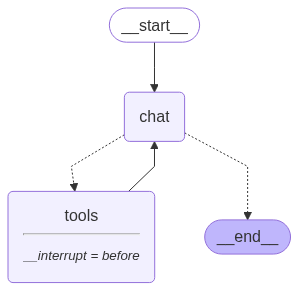

In [38]:
#可视化状态图
from IPython.display import Image, display

try:
    display(Image(graph_builder.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
# 执行工作流
user_input = "我正在学习langgraph，请帮我获取当前时间"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph_builder.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

我正在学习langgraph，请帮我获取当前时间
================================== Ai Message ==================================
Tool Calls:
  get_date (call_dc67e46ce95b4858a2b5c5)
 Call ID: call_dc67e46ce95b4858a2b5c5
  Args:


In [40]:
snapshot = graph_builder.get_state(config)
snapshot.next

('tools',)

In [41]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'get_date',
  'args': {},
  'id': 'call_dc67e46ce95b4858a2b5c5',
  'type': 'tool_call'}]

In [42]:
existing_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dc67e46ce95b4858a2b5c5', 'function': {'arguments': '{}', 'name': 'get_date'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 149, 'total_tokens': 164, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-e60ce398-c6d5-9d70-b19a-39dfbb95df3e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c9bb2e8d-6163-43fd-87df-7f80d5ecb91f-0', tool_calls=[{'name': 'get_date', 'args': {}, 'id': 'call_dc67e46ce95b4858a2b5c5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 15, 'total_tokens': 164, 'input_token_details': {}, 'output_token_details': {}})

In [44]:
# None不会向当前状态添加任何新内容，使其恢复到从未中断过的状态
events = graph_builder.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_date (call_dc67e46ce95b4858a2b5c5)
 Call ID: call_dc67e46ce95b4858a2b5c5
  Args:
================================= Tool Message =================================
Name: get_date

2025-06-01
================================== Ai Message ==================================

当前日期是2025年6月1日。


In [45]:
graph_builder.checkpointer.get_tuple(config).checkpoint['channel_values']

{'messages': [HumanMessage(content='我正在学习langgraph，请帮我获取当前时间', additional_kwargs={}, response_metadata={}, id='c61b2f1e-49a9-42a0-9050-71526797bd31'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dc67e46ce95b4858a2b5c5', 'function': {'arguments': '{}', 'name': 'get_date'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 149, 'total_tokens': 164, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-e60ce398-c6d5-9d70-b19a-39dfbb95df3e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c9bb2e8d-6163-43fd-87df-7f80d5ecb91f-0', tool_calls=[{'name': 'get_date', 'args': {}, 'id': 'call_dc67e46ce95b4858a2b5c5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 15, 'total_tokens': 164, 'input_token_details': {}, 'output_token_details': {}}),
  ToolMessage(content

In [46]:
graph_builder.invoke({"messages": [("user", '你是谁')]}, config)


{'messages': [HumanMessage(content='我正在学习langgraph，请帮我获取当前时间', additional_kwargs={}, response_metadata={}, id='c61b2f1e-49a9-42a0-9050-71526797bd31'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dc67e46ce95b4858a2b5c5', 'function': {'arguments': '{}', 'name': 'get_date'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 149, 'total_tokens': 164, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-e60ce398-c6d5-9d70-b19a-39dfbb95df3e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c9bb2e8d-6163-43fd-87df-7f80d5ecb91f-0', tool_calls=[{'name': 'get_date', 'args': {}, 'id': 'call_dc67e46ce95b4858a2b5c5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 15, 'total_tokens': 164, 'input_token_details': {}, 'output_token_details': {}}),
  ToolMessage(content